# COVID Testing and Health Equity 


In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
pd.options.display.float_format = "{:,.0f}".format


## 1. Import and clean MTA turnstile data
Source: http://web.mta.info/developers/turnstile.html

In [2]:
# Load data from April, May, and June 2019, data is loaded on Saturdays.

def get_data_parse_dt(week_nums):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    dfs = []
    for week_num in week_nums:
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url, 
                               parse_dates=[['DATE','TIME']], 
                               usecols = [0,1,2,3,4,6,7,8,9], 
                               keep_date_col=True))
    return pd.concat(dfs)


In [3]:
# Create a datetime column using data from columns DATE and TIME during import
week_nums = [190406, 190413, 190420, 190427, 190504, 190511, 190518, 190525, 190601, 190608, 190615, 190622, 190629]

df = get_data_parse_dt(week_nums)
df

,DATE_TIME,C/A,UNIT,SCP,STATION,LINENAME,DATE,TIME,DESC,ENTRIES
0,2019-03-30 00:00:00,A002,R051,02-00-00,59 ST,NQR456W,03/30/2019,00:00:00,REGULAR,6999064
1,2019-03-30 04:00:00,A002,R051,02-00-00,59 ST,NQR456W,03/30/2019,04:00:00,REGULAR,6999084
2,2019-03-30 08:00:00,A002,R051,02-00-00,59 ST,NQR456W,03/30/2019,08:00:00,REGULAR,6999107
3,2019-03-30 12:00:00,A002,R051,02-00-00,59 ST,NQR456W,03/30/2019,12:00:00,REGULAR,6999214
4,2019-03-30 16:00:00,A002,R051,02-00-00,59 ST,NQR456W,03/30/2019,16:00:00,REGULAR,6999451
...,...,...,...,...,...,...,...,...,...,...
205958,2019-06-28 05:00:00,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,06/28/2019,05:00:00,REGULAR,5554
205959,2019-06-28 09:00:00,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,06/28/2019,09:00:00,REGULAR,5554
205960,2019-06-28 13:00:00,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,06/28/2019,13:00:00,REGULAR,5554
205961,2019-06-28 17:00:00,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,06/28/2019,17:00:00,REGULAR,5554


In [4]:
# How many unique values in each column
df.nunique()

DATE_TIME     172268
C/A              747
UNIT             469
SCP              223
STATION          378
LINENAME         114
DATE              91
TIME           64013
DESC               2
ENTRIES      1909914
dtype: int64

In [5]:
df['STATION'].nunique()
# There are 378 stations

378

In [6]:
df.columns

Index(['DATE_TIME', 'C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DATE',
       'TIME', 'DESC', 'ENTRIES'],
      dtype='object')

In [7]:
# Strip whitespace from column names
df.columns = [column.strip() for column in df.columns]
df.columns

Index(['DATE_TIME', 'C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DATE',
       'TIME', 'DESC', 'ENTRIES'],
      dtype='object')

## 2. Select late night entry data

In [8]:
late_night_mask = df.copy()

In [9]:
# Mask selects the interval between 12:00 AM and 4:00 AM 
late_night_mask = (df['TIME'] == '04:00:00')
late_night_df = df[late_night_mask]
late_night_df.head(2)

,DATE_TIME,C/A,UNIT,SCP,STATION,LINENAME,DATE,TIME,DESC,ENTRIES
1,2019-03-30 04:00:00,A002,R051,02-00-00,59 ST,NQR456W,03/30/2019,04:00:00,REGULAR,6999084
7,2019-03-31 04:00:00,A002,R051,02-00-00,59 ST,NQR456W,03/31/2019,04:00:00,REGULAR,6999983


In [10]:
# Confirm df only has data from the 4:00 AM interval
late_night_df.TIME.unique()

array(['04:00:00'], dtype=object)

## 3. Calculate late night entries

In [11]:
late_night_entries_df = late_night_df.copy()
late_night_entries_df.head(2)

,DATE_TIME,C/A,UNIT,SCP,STATION,LINENAME,DATE,TIME,DESC,ENTRIES
1,2019-03-30 04:00:00,A002,R051,02-00-00,59 ST,NQR456W,03/30/2019,04:00:00,REGULAR,6999084
7,2019-03-31 04:00:00,A002,R051,02-00-00,59 ST,NQR456W,03/31/2019,04:00:00,REGULAR,6999983


In [12]:
# What type of data are in the DESC column? REGULAR and RECOVR AUD
# How many of the entries are RECOVR AUD? Can we filter them out? Yes, small percentage. 
late_night_entries_df.DESC.value_counts()

REGULAR       223797
RECOVR AUD      1076
Name: DESC, dtype: int64

In [13]:
# Mask selects the REGULAR entries in the DESC column
desc_mask = (late_night_entries_df['DESC'] == 'REGULAR')
late_night_entries_df = (late_night_entries_df[desc_mask])

In [14]:
# Confirm that "C/A", "UNIT", "SCP", "STATION", "DATE_TIME" is unique
(late_night_entries_df
 .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False)).head(5)

,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES
0,A002,R051,02-00-00,59 ST,2019-03-30 04:00:00,1
149202,R148,R033,01-03-00,TIMES SQ-42 ST,2019-03-30 04:00:00,1
149191,R148,R033,01-00-01,TIMES SQ-42 ST,2019-06-18 04:00:00,1
149192,R148,R033,01-00-01,TIMES SQ-42 ST,2019-06-19 04:00:00,1
149193,R148,R033,01-00-01,TIMES SQ-42 ST,2019-06-20 04:00:00,1


In [15]:
# Create new columns for the previous date and entries. 
# Apply a shift to calculate the previous day's entries. 

v = (late_night_entries_df[["DATE", "ENTRIES"]].apply(lambda grp: grp.shift(1)))
late_night_entries_df['PREV_DATE'] = v['DATE']
late_night_entries_df['PREV_ENTRIES'] = v['ENTRIES']

late_night_entries_df.head(2)

,DATE_TIME,C/A,UNIT,SCP,STATION,LINENAME,DATE,TIME,DESC,ENTRIES,PREV_DATE,PREV_ENTRIES
1,2019-03-30 04:00:00,A002,R051,02-00-00,59 ST,NQR456W,03/30/2019,04:00:00,REGULAR,6999084,NaN,NaN
7,2019-03-31 04:00:00,A002,R051,02-00-00,59 ST,NQR456W,03/31/2019,04:00:00,REGULAR,6999983,03/30/2019,"6,999,084"


In [16]:
# How many stations have a counter going in reverse? 
(late_night_entries_df[late_night_entries_df['ENTRIES'] < late_night_entries_df["PREV_ENTRIES"]]
    .groupby(["C/A", "UNIT", "SCP", "STATION"])
    .size())


C/A    UNIT  SCP       STATION   
A002   R051  02-00-01  59 ST         13
             02-03-00  59 ST         13
             02-03-01  59 ST         13
             02-03-03  59 ST         13
             02-03-06  59 ST         13
                                     ..
S101A  R070  01-03-01  ST. GEORGE    13
             01-03-02  ST. GEORGE    13
             01-03-03  ST. GEORGE    13
             01-05-00  ST. GEORGE    13
             01-05-01  ST. GEORGE    13
Length: 1337, dtype: int64

In [17]:
# Adjust counter 
def get_daily_counts(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        print(row["ENTRIES"], row["PREV_ENTRIES"])
        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter


In [18]:
late_night_entries_df["LATE_NIGHT_ENTRIES"] = late_night_entries_df.apply(get_daily_counts, axis=1, max_counter=1000000)


1211485 6244921.0
6132837 1055829.0
7068485 5700185.0
11343688 7075278.0
8906748 11354247.0
112 8914543.0
4218583 144210.0
15053780 4238350.0
10972322 15067670.0
3430241 10982316.0
1448019 4269945.0
18655173 1459100.0
1706203 18671324.0
109780 1733224.0
2871665 255756.0
6020763 2901302.0
4782692 6022550.0
6064948 4786341.0
986 5784970.0
2994632 42245.0
6884639 3002297.0
1566408 6889738.0
12418301 34891.0
563844 12429375.0
3785735 573065.0
8680613 3794272.0
7121077 8687862.0
6018159 7127752.0
3686540 6023830.0
5469727 3694554.0
14649812 5478863.0
1305964 14663697.0
4051 1306861.0
8693471 4542.0
3294668 8711303.0
2302253 3307712.0
2873805 1843764.0
26712190 2886674.0
14593211 26758830.0
67617692 14617215.0
5218189 67620412.0
12525174 4476841.0
13665116 12547547.0
7710346 13685897.0
1238569560 7158178.0
689735 1238548874.0
10809812 715085.0
14712311 10821823.0
84988855 14725157.0
3404515 84993336.0
39561 3412558.0
2016323 48807.0
4172905 2717995.0
6343752 4175962.0
7523065 6349723.0
44427

3079802 4335630.0
1082760 3405050.0
1368 1086003.0
7817822 619527.0
6228444 7824728.0
1209869033 6237537.0
119032 1209853398.0
1735587 119094.0
3170415 1736326.0
1269999 3172946.0
7607709 1999329.0
6425108 7618830.0
4594540 6431391.0
14578267 4600991.0
60095357 14598825.0
370622238 60120975.0
2419317 370627586.0
6336286 2423379.0
264963 6342935.0
2697967 266263.0
500900 2701897.0
955304731 509330.0
126527 955320197.0
2559040 742632.0
19357054 2570441.0
16718039 19365719.0
14343582 16727170.0
24360015 14359557.0
10612304 24384640.0
1954482 10647876.0
6709707 1293456.0
13760015 6725571.0
2038523 14319061.0
285164 2040799.0
1420357 287049.0
7235647 1424079.0
69312 7242762.0
8267159 77025.0
1254031 8279702.0
7020100 1114238.0
2882293 7033398.0
137529671 2893168.0
287210 137545450.0
2512804 37704.0
14450 1507100.0
7307127 19447.0
2590946 7318764.0
7563817 2597717.0
492035 7573491.0
8863994 495441.0
4725995 8874784.0
6049902 4737299.0
1188908 6057532.0
1927287282 1201677.0
1598373 1927277132

3487101 155252.0
8509021 3498866.0
139456 9440591.0
2951847 123187.0
1781135 3726010.0
15121501 1790585.0
16799150 15132614.0
21986773 16813837.0
10339868 22006612.0
506541157 10346610.0
8987398 506551393.0
1628245 8998565.0
50344133 1637432.0
385643 50331648.0
51103459 386485.0
2366118 51106058.0
13366379 2371035.0
9490601 13400465.0
24402587 9518494.0
16776332 24431870.0
1397320059 16801367.0
5204700 1397340112.0
13846032 5216067.0
7187596 13861430.0
1913015 7204632.0
5398921 1934892.0
5842 5414920.0
117440512 5861.0
13558510 117440512.0
3374652 13571075.0
11477098 3385795.0
5023258 11486307.0
3380093 5033683.0
9862542 3387936.0
3038053 9880545.0
4931407 3046211.0
960687 4594012.0
4666202 963592.0
11140114 4671148.0
3447 11150414.0
11752523 671113.0
2033409798 11762637.0
5233229 2033420308.0
11474542 5242098.0
15026257 11483644.0
4789469 14882998.0
13767202 4800362.0
100667822 13778183.0
262144 100667843.0
2502872 482040.0
5939363 2508446.0
924286 6819865.0
7919987 933609.0
22086324 

11166438 2577553.0
3971182 11176021.0
2284620 3973382.0
510533 2285477.0
11178026 512392.0
1124088 11185009.0
4528132 1128434.0
634458 4531065.0
2384925 164850.0
7299264 2385168.0
3067433 7304730.0
116001 3075720.0
2680825 116528.0
1131470 2681966.0
12873937 1133928.0
4586439 12879653.0
8633416 4593498.0
36495 8637920.0
3617303 1856966.0
1811734 3618960.0
11014648 1342140.0
4211247 11023358.0
1625799 4212727.0
4713372 631179.0
1132455 4720308.0
4614299 1138450.0
10498722 4629556.0
853969 10507612.0
100771309 864724.0
8891914 100778917.0
370625 8896930.0
8870841 70569.0
2029787476 8103439.0
13880881 2029780101.0
788654 13890055.0
6087245 0.0
11016733 6094767.0
3027514 11023079.0
7958622 3031278.0
6602322 7962324.0
7193088 5769279.0
924472 7198441.0
8399315 15689.0
6837267 8408505.0
9647684 5973215.0
255065 9655447.0
9793723 266888.0
18938875 9456735.0
524368 18958540.0
4409199 262144.0
117972859 4414335.0
5091274 117976012.0
1041912 5094290.0
3016310 1045749.0
7859982 3919668.0
1189 786

6060552 117811678.0
337053 6065128.0
1657848 339733.0
350473 1659492.0
925584272 946649.0
1666315 925598273.0
2725616 1673040.0
391683 2730578.0
3467918 756195.0
1256922 3476985.0
3139399 1258963.0
1273813 3144429.0
9515402 1282825.0
1316121 9533288.0
1158651195 462400.0
510266 1158659327.0
7620140 515924.0
6512101 7625128.0
13151658 5982926.0
118012268 13160593.0
12092849 118015168.0
4712427 12095521.0
68687480 4715687.0
102258071 68699556.0
4326968 102266583.0
7223731 4329736.0
5424631 7225120.0
9248493 5431452.0
13590878 9254741.0
8189762 13597534.0
10792295 8195705.0
2695439 10796999.0
7454567 2699297.0
625172 7466082.0
9986118 633569.0
7642585 9991417.0
353180532 7647260.0
4540688 353184581.0
557293 4547244.0
1992706 735553.0
469790 1995957.0
5610602 471977.0
304622 4919265.0
1579950591 13445.0
1579 1579955466.0
826344724 123990.0
1914821714 826361115.0
3583756 1914836341.0
874630 3587628.0
5623859 881533.0
12769 5632303.0
6483559 23029.0
10772071 6496471.0
4805044 10784114.0
1287

9849640 1549853.0
3036193 9857492.0
218806 2912629.0
1450473 220730.0
136071 1451587.0
1561801 137755.0
1675673 673597.0
4464270 91438.0
1658972 4471070.0
7264290 1663272.0
2986769 7268152.0
5283164 2991654.0
9102831 5294168.0
2750080 9113691.0
1486386 2756232.0
1291155042 1811884.0
2510962 1291153325.0
523759 2136563.0
2772857 509514.0
6865664 2776172.0
154740 5494985.0
3193252 156896.0
138614 3194768.0
5484070 140720.0
9439222 5487610.0
4331148 9445345.0
21274956 4142304.0
1082 21289520.0
1790386 578971.0
20504 1793072.0
2066982530 23777.0
1797932 2066974955.0
5777772 1805575.0
260433 5789158.0
509203612 393743.0
228140 509210324.0
101101188 485839.0
4540278 101102215.0
557 4542057.0
3467834 0.0
441567 3475057.0
4512534 449563.0
5626234 4520915.0
1084 5632486.0
3682549 0.0
414526 3690247.0
8280503 498919.0
1611175 8286181.0
59559 1670562.0
10082504 107077.0
5386735 10094637.0
8003891 5393036.0
83886433 8013397.0
67108864 83886433.0
86661863 67108864.0
9235076 86669228.0
3166219 92460

17839360 14064069.0
10 17839378.0
10189789 10.0
1891812042 10207561.0
4392366 1891798256.0
747448 4396443.0
2772770 753557.0
53198018 3439928.0
68815862 53221390.0
1469025 68833587.0
1718649232 1470408.0
10243658 1718676480.0
6934119 10262435.0
16391569 6949252.0
36958007 16405512.0
2469 36966387.0
8119592 2469.0
11936 8134158.0
7953990 719.0
2856155 7973462.0
9121714 2865619.0
4666808 9131010.0
6273174 4674880.0
1775550 6279611.0
5014255 1780624.0
819836 5243875.0
11605068 830826.0
1514359 11614631.0
5392029 2156233.0
6803185 5080959.0
1526280 6809584.0
10135712 1533339.0
1613784 10143759.0
3235493 1575123.0
1766305 3241959.0
3171 1769488.0
5302653 7526.0
2319343 5527237.0
1097 2321241.0
1037622541 314565.0
1257342 1037629544.0
639595714 1577238.0
4993529 639606348.0
6062764 5000919.0
3790357 6068905.0
135174263 4637900.0
655251084 135177630.0
3588747 655254411.0
21642996 4527058.0
1361685 21661379.0
2631920 1119184.0
10992394 2634847.0
3851216 10995515.0
10883767 3864348.0
727167 108

16276685 9558947.0
1393715 16298717.0
24110943 1410190.0
6051103 24123005.0
3646275 6058989.0
20465970 3652150.0
3804389 20473916.0
29253480 3814903.0
31273954 29267695.0
23696563 31289870.0
972651073 23711730.0
4667105 972628392.0
3538702 5461281.0
4832427 3550386.0
13915253 4845150.0
3771445 13930424.0
991449330 4364377.0
117443583 991454570.0
168165376 117443594.0
18363622 168165376.0
189828 18380468.0
3256383 389089.0
15530925 3266413.0
224178 15542635.0
50450004 239271.0
315286 50459242.0
7317437 1203994.0
4986345 7331448.0
840686 4993875.0
5292850 1163934.0
1228151 5300505.0
7466030 2049247.0
6026765 7473152.0
1954707 6035228.0
46103 1967725.0
607159732 546066.0
237638 607171045.0
1781167147 246232.0
3642380 1781173920.0
1225206966 3648139.0
140401584 1225213546.0
6442500 140411440.0
8873671 6456830.0
1108311810 8882495.0
18221663 1108326037.0
3809 18236790.0
203973458 458752.0
217891 203976078.0
8209833 1258240.0
195301 7811148.0
6133908 199308.0
8114076 6138127.0
2869288 812294

28877 12239059.0
2375266 35772.0
170237 2379998.0
8248296 174493.0
4095290 8252761.0
5321903 4099820.0
1173 5324205.0
2543089 5.0
10120307 2158937.0
60276 10124425.0
4597253 64168.0
8459989 4607490.0
1920835 8471180.0
4910731 1938405.0
9056644 4920007.0
6295410 9061044.0
928068 6301001.0
7559099 932701.0
1050620 7565036.0
2115042 479434.0
451334 2116864.0
1680987 363825.0
3116851 1681783.0
1881242 3120532.0
5580252 1886472.0
1292313 5583523.0
1105306 2335435.0
4861842 179684.0
3706853 4866812.0
1355047 3711340.0
2509138 1351015.0
5213376 2513952.0
4186060 5220834.0
3104284 4188818.0
4928736 3109608.0
9075 4930993.0
11359500 13319.0
8719774 11366290.0
1003611 8728753.0
3065933 1014776.0
4349356 3078591.0
307696 4361912.0
5021100 41276.0
887345 5027305.0
2335809 895978.0
460513 2340590.0
2324166 757370.0
977665 2324799.0
72079 1620353.0
1812859 544090.0
2752647 1674463.0
50345362 2723492.0
117440512 50345366.0
8781782 117440512.0
44769 8787471.0
188784 1810897.0
10494135 631023.0
3819683

4411557 227509.0
15189007 4425151.0
11073036 15198285.0
3515173 11080022.0
1592231 4370344.0
18861085 1605268.0
2055286 18880313.0
204938 2088133.0
3167622 478017.0
6061669 3194830.0
4866767 6065758.0
6147689 4874398.0
1018 5869651.0
12544437 141169.0
675397 12555922.0
3887713 685175.0
8768027 3896636.0
7199125 8775751.0
6083978 7206257.0
3770094 6090030.0
5570390 3777406.0
14798007 5579538.0
1315881 14810824.0
9389 1316799.0
8893331 9835.0
3450586 8910782.0
2413545 3463372.0
3018554 1915980.0
27042702 3030795.0
14893859 27019316.0
67653707 14919684.0
5277896 67656951.0
12785777 4647098.0
13906899 12807993.0
7933514 13927245.0
1238322797 7395183.0
988353 1238302554.0
10949604 1013227.0
14868173 10961818.0
85040711 14881650.0
3500662 85044948.0
152199 3508231.0
2109548 161127.0
4210097 2791375.0
6416511 4213290.0
7624549 6422561.0
4570399 7632757.0
82821 4580535.0
6883565 84930.0
5181137 6893856.0
6483263 5187136.0
9911532 6490487.0
10930816 9921682.0
8590701 10947152.0
85839901 8601504

507 3265224.0
100663296 509.0
189398 100663296.0
805 1476878.0
419446441 806.0
755739504 419446441.0
7467845 755748343.0
6201134 7476890.0
16433945 6209973.0
15119761 16446330.0
1055070 15131787.0
553649466 1524408.0
229572623 553649472.0
12160 229572623.0
2010928 15248.0
3763421 2016495.0
1324489 3770249.0
3673522 1332202.0
155810 3683588.0
1407378 157458.0
7566074 1410538.0
2008521 7570277.0
522 2014985.0
100663296 522.0
68372294 100663296.0
13378457 68379896.0
736086 13386217.0
8386931 741755.0
11188131 8393225.0
15375108 11197177.0
6277047 15387913.0
7920494 6280776.0
3279213 7923782.0
4972425 3664513.0
1694679 4976978.0
3267716 68639.0
5898555 4100075.0
0 5898555.0
2031663 0.0
3150063 2034720.0
546090 3153419.0
1556523 252973.0
101117728 950904.0
11701276 101119668.0
1709118 11704737.0
3340580 1711672.0
134218085 1448763.0
20 134218091.0
68417219 540984.0
6844193 68425379.0
1410030183 6852625.0
10973516 1410036472.0
1840320 10977922.0
773501 1844105.0
6287206 1083570.0
184367 7187

560459 5447851.0
2871815 571642.0
6161830 2882099.0
720292 6172195.0
1376929 2795.0
535 1377289.0
117440645 0.0
0 117440645.0
9322870 0.0
1884923 9325568.0
84607 1888837.0
2166727 89060.0
6326697 2170654.0
8103 6330065.0
1043082 18291.0
510 3272854.0
100663296 511.0
190889 100663296.0
807 1480088.0
419446441 808.0
755750003 419446441.0
7478612 755759051.0
6211644 7487618.0
16448601 6220315.0
15133983 16460971.0
1065915 15146178.0
553649473 1532561.0
229572623 553649479.0
15908 229572623.0
2017561 19478.0
3771593 2022826.0
1333784 3778151.0
3685750 1341180.0
157854 3695812.0
1411141 160131.0
7571087 1414462.0
2016174 7575235.0
522 2022517.0
100663296 522.0
68381362 100663296.0
13387538 68388847.0
742608 13396775.0
8394245 749147.0
11198631 8401509.0
15390226 11208298.0
6281440 15404368.0
7924370 6285609.0
3281879 7928202.0
4977786 3668474.0
1695987 4983653.0
3271803 74396.0
5898555 4106316.0
0 5898555.0
2035316 0.0
3154091 2038306.0
550619 3157420.0
1560960 255568.0
101120055 952433.0
1

In [19]:
late_night_entries_df.head(2)

,DATE_TIME,C/A,UNIT,SCP,STATION,LINENAME,DATE,TIME,DESC,ENTRIES,PREV_DATE,PREV_ENTRIES,LATE_NIGHT_ENTRIES
1,2019-03-30 04:00:00,A002,R051,02-00-00,59 ST,NQR456W,03/30/2019,04:00:00,REGULAR,6999084,NaN,NaN,NaN
7,2019-03-31 04:00:00,A002,R051,02-00-00,59 ST,NQR456W,03/31/2019,04:00:00,REGULAR,6999983,03/30/2019,"6,999,084",899


In [20]:
# Drop row with the March 31, 2019 data, used it to calculate the previous entries, no longer neeeded. 
late_night_entries_df.dropna(subset=["PREV_DATE"], axis=0, inplace=True)
late_night_entries_df.head(2)


,DATE_TIME,C/A,UNIT,SCP,STATION,LINENAME,DATE,TIME,DESC,ENTRIES,PREV_DATE,PREV_ENTRIES,LATE_NIGHT_ENTRIES
7,2019-03-31 04:00:00,A002,R051,02-00-00,59 ST,NQR456W,03/31/2019,04:00:00,REGULAR,6999983,03/30/2019,"6,999,084",899
13,2019-04-01 04:00:00,A002,R051,02-00-00,59 ST,NQR456W,04/01/2019,04:00:00,REGULAR,7000539,03/31/2019,"6,999,983",556


In [21]:
# Add up all turnstiles by station and reset index 
late_night_entries_df = (late_night_entries_df.groupby(['STATION', 'DATE_TIME', 'LINENAME'])
                         [['LATE_NIGHT_ENTRIES']]
                         .sum()).reset_index()
late_night_entries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22142 entries, 0 to 22141
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   STATION             22142 non-null  object        
 1   DATE_TIME           22142 non-null  datetime64[ns]
 2   LINENAME            22142 non-null  object        
 3   LATE_NIGHT_ENTRIES  22142 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 692.1+ KB


In [22]:
# Add column DAY_OF_WEEK to display day of week (Monday = 0, Sunday = 6)
late_night_entries_df['DAY_OF_WEEK'] = pd.to_datetime(late_night_entries_df['DATE_TIME']).dt.dayofweek
late_night_entries_df.head(2)


,STATION,DATE_TIME,LINENAME,LATE_NIGHT_ENTRIES,DAY_OF_WEEK
0,1 AV,2019-03-30 04:00:00,L,"1,618,348",5
1,1 AV,2019-03-31 04:00:00,L,"15,402",6


## 4. Calculate rolling mean of late night entries

In [23]:
rolling_mean_df = late_night_entries_df.copy()
rolling_mean_df.head(2)

,STATION,DATE_TIME,LINENAME,LATE_NIGHT_ENTRIES,DAY_OF_WEEK
0,1 AV,2019-03-30 04:00:00,L,"1,618,348",5
1,1 AV,2019-03-31 04:00:00,L,"15,402",6


In [24]:
# Add column ROLLING_MEAN to capture the weekly rolling mean for each station 
rolling_mean_df['ROLLING_MEAN'] = (rolling_mean_df
                        .groupby('STATION')['LATE_NIGHT_ENTRIES']
                        .transform(lambda x: x.rolling(7,1).mean()))
rolling_mean_df[['STATION','DATE_TIME','LATE_NIGHT_ENTRIES','ROLLING_MEAN','DAY_OF_WEEK']].head(2) 
# rolling_mean_df

,STATION,DATE_TIME,LATE_NIGHT_ENTRIES,ROLLING_MEAN,DAY_OF_WEEK
0,1 AV,2019-03-30 04:00:00,"1,618,348","1,618,348",5
1,1 AV,2019-03-31 04:00:00,"15,402","816,875",6


In [25]:
# Mask selects the last day of each station's rolling mean; Sunday=6
last_rolling_day_mask = (rolling_mean_df['DAY_OF_WEEK'] == 6)
rolling_mean_df = rolling_mean_df[last_rolling_day_mask]
rolling_mean_df.head(2)

,STATION,DATE_TIME,LINENAME,LATE_NIGHT_ENTRIES,DAY_OF_WEEK,ROLLING_MEAN
1,1 AV,2019-03-31 04:00:00,L,"15,402",6,"816,875"
8,1 AV,2019-04-07 04:00:00,L,"16,725",6,"254,088"


In [26]:
# Comfirm df only has Sunday
rolling_mean_df.DAY_OF_WEEK.unique()


array([6])

In [27]:
# How many stations? 213; started with 378 
# Some stations were ommited during clean up. 
# Perhaps some stations don't have late night service or were closed for repair. 
len(rolling_mean_df.STATION.unique())


213

In [28]:
# Sort by ROLLING_MEAN and reset index 
rolling_mean_df = rolling_mean_df.sort_values('ROLLING_MEAN', ascending=False).reset_index(drop=True)
rolling_mean_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3167 entries, 0 to 3166
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   STATION             3167 non-null   object        
 1   DATE_TIME           3167 non-null   datetime64[ns]
 2   LINENAME            3167 non-null   object        
 3   LATE_NIGHT_ENTRIES  3167 non-null   float64       
 4   DAY_OF_WEEK         3167 non-null   int64         
 5   ROLLING_MEAN        3167 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 148.6+ KB


In [29]:
rolling_mean_group = (rolling_mean_df
                      .groupby('STATION')[['ROLLING_MEAN']].mean())


In [30]:
rolling_mean_group.reset_index(inplace=True)

In [31]:
# Select top stations with the highest rolling mean on Sunday
rolling_mean_group.sort_values('ROLLING_MEAN', ascending=False)
rolling_mean_group_top = rolling_mean_group.loc[:9]
rolling_mean_group_top

,STATION,ROLLING_MEAN
0,1 AV,"328,632"
1,103 ST-CORONA,"112,645"
2,104 ST,"216,736"
3,110 ST,"140,304"
4,111 ST,"80,648"
5,121 ST,"443,800"
6,125 ST,"219,008"
7,135 ST,"209,658"
8,138/GRAND CONC,"102,414"
9,14 ST,"1,162,569"


## 5. Plot top stations by highest late night rolling mean

### Which stations outside of Manhattan have high late night entries? 

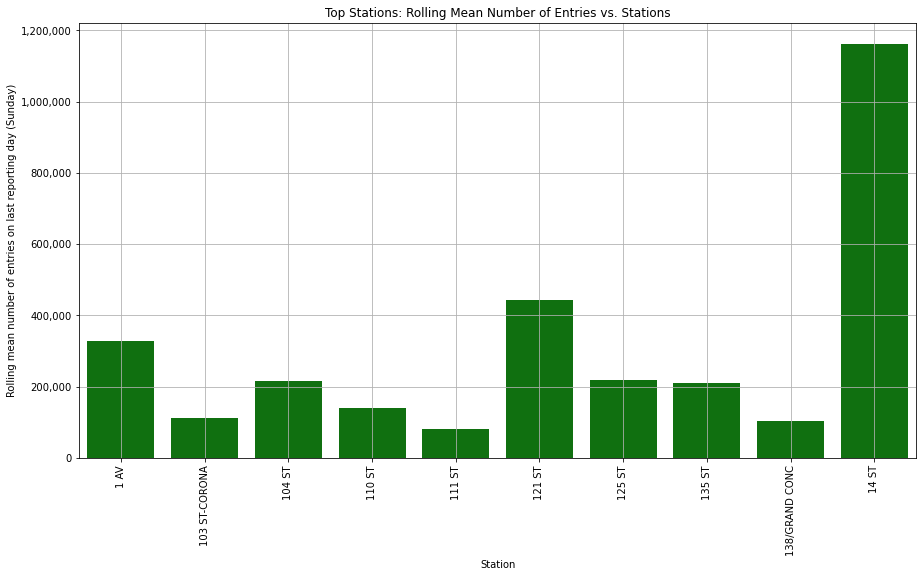

In [32]:
# Plot top stations: Rolling mean number of entres vs stations

plt.figure(figsize = (15,8))
ax = sns.barplot(x = 'STATION', y = 'ROLLING_MEAN', data = rolling_mean_group_top, color='green')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
ax.set(title='Top Stations: Rolling Mean Number of Entries vs. Stations')
ax.set(xlabel=('Station'))
ax.set(ylabel=('Rolling mean number of entries on last reporting day (Sunday)'))
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.grid();


One station outside of Manhattan is both in Queens and on the 7 train. 
Let's look at the stations along the 7 line in Queens. 

## 6. Plot 7 train stations in Queens 

In [33]:
seven_line_df = rolling_mean_df.copy() # Using df with rolling mean
seven_line_df.head(2)

,STATION,DATE_TIME,LINENAME,LATE_NIGHT_ENTRIES,DAY_OF_WEEK,ROLLING_MEAN
0,34 ST-PENN STA,2019-03-31 04:00:00,123,"17,001",6,"6,198,087"
1,34 ST-HERALD SQ,2019-03-31 04:00:00,BDFMNQRW,"78,790",6,"5,511,591"


In [34]:
# Looking for linename of interest: 7 line 
seven_line_df = seven_line_df[seven_line_df['LINENAME'].str.contains('7', na=False)] 
seven_line_df.head(10)
# The 7 train shares stations with other train lines. Will omit multi-train stations in this analysis. 
# Line name as recorded in dataset: 7


,STATION,DATE_TIME,LINENAME,LATE_NIGHT_ENTRIES,DAY_OF_WEEK,ROLLING_MEAN
5,42 ST-PORT AUTH,2019-03-31 04:00:00,ACENQRS1237W,"36,598",6,"3,474,060"
18,GRD CNTRL-42 ST,2019-03-31 04:00:00,4567S,"38,103",6,"2,829,847"
33,34 ST-HUDSON YD,2019-03-31 04:00:00,7,"19,111",6,"2,674,048"
39,42 ST-BRYANT PK,2019-03-31 04:00:00,BDFM7,"15,676",6,"2,400,286"
50,FLUSHING-MAIN,2019-03-31 04:00:00,7,4,6,"2,000,721"
89,5 AVE,2019-03-31 04:00:00,7BDFM,"5,583",6,"1,651,434"
97,TIMES SQ-42 ST,2019-03-31 04:00:00,1237ACENQRS,"17,042",6,"1,538,861"
101,42 ST-BRYANT PK,2019-05-19 04:00:00,BDFM7,"19,682",6,"1,478,193"
116,COURT SQ,2019-03-31 04:00:00,7,"4,172",6,"1,312,422"
138,TIMES SQ-42 ST,2019-03-31 04:00:00,1237ACENQRSW,"45,572",6,"1,240,203"


In [35]:
# Mask selects the 7 train only stations
seven_mask = (seven_line_df['LINENAME'] == '7')
seven_line_df = seven_line_df[seven_mask]
seven_line_df.head(2)

,STATION,DATE_TIME,LINENAME,LATE_NIGHT_ENTRIES,DAY_OF_WEEK,ROLLING_MEAN
33,34 ST-HUDSON YD,2019-03-31 04:00:00,7,"19,111",6,"2,674,048"
50,FLUSHING-MAIN,2019-03-31 04:00:00,7,4,6,"2,000,721"


In [36]:
# Comfirm df has only 7 line data
seven_line_df.LINENAME.unique()

array(['7'], dtype=object)

In [37]:
# How many 7 train stations in this dataset? 12
len(seven_line_df.STATION.unique())

12

In [38]:
# How many stations in Queens? All but one, 34 ST-HUDSON YD.   
seven_line_df.STATION.unique()

array(['34 ST-HUDSON YD', 'FLUSHING-MAIN', 'COURT SQ', 'VERNON-JACKSON',
       '46 ST BLISS ST', '90 ST-ELMHURST', '40 ST LOWERY ST',
       '82 ST-JACKSON H', '33 ST-RAWSON ST', '103 ST-CORONA', '111 ST',
       'JUNCTION BLVD'], dtype=object)

In [39]:
# Mask selects only the Queens stations
queens_mask = (seven_line_df['STATION'] != '34 ST-HUDSON YD')
seven_line_df = seven_line_df[queens_mask]
seven_line_df.head(5)

,STATION,DATE_TIME,LINENAME,LATE_NIGHT_ENTRIES,DAY_OF_WEEK,ROLLING_MEAN
50,FLUSHING-MAIN,2019-03-31 04:00:00,7,4,6,"2,000,721"
116,COURT SQ,2019-03-31 04:00:00,7,"4,172",6,"1,312,422"
148,VERNON-JACKSON,2019-03-31 04:00:00,7,"10,591",6,"1,208,780"
158,46 ST BLISS ST,2019-03-31 04:00:00,7,"8,797",6,"1,158,996"
421,90 ST-ELMHURST,2019-03-31 04:00:00,7,"11,087",6,"830,892"


### Which 7 train stations in Queens have high late night entries? 

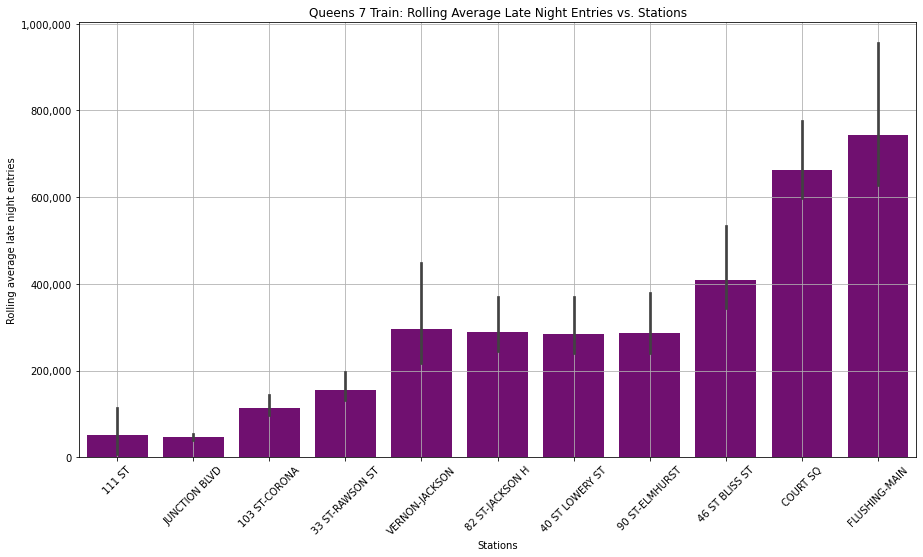

In [40]:
# Plot 7 line in Queens: Rolling average late night entries vs Queens 7 train stations

plt.figure(figsize = (15,8))
ax = sns.barplot(x = 'STATION', y = 'ROLLING_MEAN',data = seven_line_df.sort_values('ROLLING_MEAN'), color='purple')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set(title='Queens 7 Train: Rolling Average Late Night Entries vs. Stations')
ax.set(xlabel=('Stations'))
ax.set(ylabel=('Rolling average late night entries'))
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.grid();


The range of people entering a station on the 7 train during late-night hours varies. 
One station has high late night entries.<br/>
What days are the busiest at Flushing Station? 



## 7. Plot average late night entries at Flushing Station by day of week

In [41]:
flushing_df = late_night_entries_df.copy() # Using df without rolling mean

In [42]:
# Mask selects FLUSHING-MAIN
flushing_mask = (flushing_df['STATION'] == 'FLUSHING-MAIN')
flushing_df = flushing_df[flushing_mask]


In [43]:
# Confirm df only has Flushing data
flushing_df.STATION.unique()


array(['FLUSHING-MAIN'], dtype=object)

In [44]:
flushing_df.head(2)

,STATION,DATE_TIME,LINENAME,LATE_NIGHT_ENTRIES,DAY_OF_WEEK
14305,FLUSHING-MAIN,2019-03-30 04:00:00,7,"4,001,438",5
14306,FLUSHING-MAIN,2019-03-31 04:00:00,7,4,6


In [45]:
# Calculate Flushing WEEK_DAY_MEAN
flushing_df['WEEK_DAY_MEAN'] = (flushing_df
                                .groupby('DAY_OF_WEEK')['LATE_NIGHT_ENTRIES']
                                .transform(lambda x: x.mean()))
flushing_df.head(10)

,STATION,DATE_TIME,LINENAME,LATE_NIGHT_ENTRIES,DAY_OF_WEEK,WEEK_DAY_MEAN
14305,FLUSHING-MAIN,2019-03-30 04:00:00,7,"4,001,438",5,"4,168,255"
14306,FLUSHING-MAIN,2019-03-31 04:00:00,7,4,6,"27,901"
14307,FLUSHING-MAIN,2019-04-01 04:00:00,7,37,0,"20,948"
14308,FLUSHING-MAIN,2019-04-02 04:00:00,7,"57,655",1,"55,069"
14309,FLUSHING-MAIN,2019-04-03 04:00:00,7,"59,024",2,"58,079"
14310,FLUSHING-MAIN,2019-04-04 04:00:00,7,"59,802",3,"59,085"
14311,FLUSHING-MAIN,2019-04-05 04:00:00,7,"60,840",4,"58,426"
14312,FLUSHING-MAIN,2019-04-06 04:00:00,7,"4,016,794",5,"4,168,255"
14313,FLUSHING-MAIN,2019-04-07 04:00:00,7,"40,710",6,"27,901"
14314,FLUSHING-MAIN,2019-04-08 04:00:00,7,"31,202",0,"20,948"


In [46]:
# Mask selects every day but Saturday=5. 
# Saturdays may record people going out late to bars or nightclubs
saturday_mask = (flushing_df['DAY_OF_WEEK'] != 5)
flushing_df = flushing_df[saturday_mask]
flushing_df.head(5)

,STATION,DATE_TIME,LINENAME,LATE_NIGHT_ENTRIES,DAY_OF_WEEK,WEEK_DAY_MEAN
14306,FLUSHING-MAIN,2019-03-31 04:00:00,7,4,6,"27,901"
14307,FLUSHING-MAIN,2019-04-01 04:00:00,7,37,0,"20,948"
14308,FLUSHING-MAIN,2019-04-02 04:00:00,7,"57,655",1,"55,069"
14309,FLUSHING-MAIN,2019-04-03 04:00:00,7,"59,024",2,"58,079"
14310,FLUSHING-MAIN,2019-04-04 04:00:00,7,"59,802",3,"59,085"


### What days are the busiest at Flushing Station?

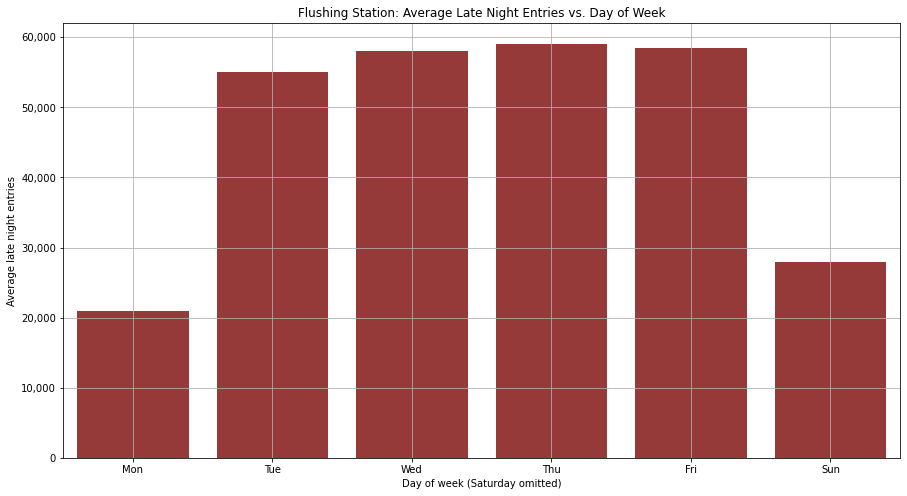

In [47]:
# Plot Flushing average week: Average late night entries vs day of week

plt.figure(figsize = (15,8))
ax = sns.barplot(x = 'DAY_OF_WEEK', y = 'WEEK_DAY_MEAN',data = flushing_df, color='brown')
ax.set(title='Flushing Station: Average Late Night Entries vs. Day of Week')
ax.set(xlabel=('Day of week (Saturday omitted)'))
ax.set_xticklabels(['Mon','Tue','Wed','Thu','Fri','Sun'],rotation = 0)
ax.set(ylabel=('Average late night entries'))
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.grid();


Tuesday through Friday have the highest late night entries at the Flushing station.